<a href="https://colab.research.google.com/github/Linsen-gao-457/AutoTune-TR/blob/main/AutoTune_TR_vs_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 10.1 MB/s eta 0:00:00


In [2]:
!pip install tabulate

In [3]:
import os
import pickle
import tempfile
from pathlib import Path
from functools import partial
from tabulate import tabulate
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

from ray import train, tune
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
from ray.tune import Trainable, CLIReporter

from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
import tempfile
from pathlib import Path
import pandas as pd


In [4]:
def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform
    )

    return trainset, testset

In [5]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [6]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
class SubsampledTrustRegion:
    def __init__(self, parameters, lr, radius=0.01):
        self.parameters = list(parameters)
        self.lr = lr
        self.radius = radius
        self.internal_state = {}
    def step(self, loss):
        self.zero_grad()

        grads = torch.autograd.grad(loss, self.parameters, create_graph=True)

        for p, g in zip(self.parameters, grads):
            if g is None:
                continue

            hvp = torch.autograd.grad(
                outputs=g, inputs=p, grad_outputs=g.detach(), retain_graph=True
            )[0]

            denom = hvp.norm() + 1e-6
            step = -self.lr * g / denom
            step = step.clamp(min=-self.radius, max=self.radius)

            with torch.no_grad():
              p.data = p.data + step


    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def state_dict(self):
        return {"lr": self.lr, "internal_state": self.internal_state}

    def load_state_dict(self, state_dict):
        self.lr = state_dict.get("lr", self.lr)
        self.radius = state_dict.get("radius", self.radius)


In [8]:
def train_cifar(config, data_dir=None):
    print(f"Launching trial with config: {config}")
    torch.autograd.set_detect_anomaly(True)
    net = Net(config["l1"], config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()

    if config["optimizer"] == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "tr":
        optimizer = SubsampledTrustRegion(net.parameters(), lr=config["lr"])
    else:
        raise ValueError(f"Unknown optimizer: {config['optimizer']}")

    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            if config["optimizer"] == "sgd":
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainset, testset = load_data(data_dir)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_subset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=2)

    for epoch in range(start_epoch, 10):
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            if config["optimizer"] == "tr":
                optimizer.step(loss)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / epoch_steps))
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)
            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report({"loss": val_loss / val_steps, "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")

100%|██████████| 170M/170M [01:22<00:00, 2.07MB/s]
2025-04-23 13:27:47,603	INFO worker.py:1852 -- Started a local Ray instance.
2025-04-23 13:27:49,156	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-04-23 13:27:49,228	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-04-23 13:27:49,229	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2025-04-23_13-27-49   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 20                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2025-04-23_13-27-49

Trial status: 20 PENDING
Current time: 2025-04-23 13:27:49. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------+
| Trial name                status   |
+------------------------------------+
| train_cifar_c02a1_00000   PENDING  |
| train_cifar_c02a1_00001   PENDING  |
| train_cifar_c02a1_00002   PENDING  |
| train_cifar_c02a1_00003   PENDI

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 13:32:50. Total running time: 5min 1s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         1            295.523   2.30487       0.0994 |
| train_cifar_c02a1_00001   PENDING                                                     |
| train_cifar_c02a1_00002   PENDING                                                     |
| train_cifar_c02a1_00003   PENDING                                                     |
| train_cifar_c02a1_00004   PENDING                                                     |
| train_cifar_c02a1_00005   PENDING                                                     |
| train_cifar_

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 13:37:51. Total running time: 10min 1s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         2            585.735   2.30571       0.1014 |
| train_cifar_c02a1_00001   PENDING                                                     |
| train_cifar_c02a1_00002   PENDING                                                     |
| train_cifar_c02a1_00003   PENDING                                                     |
| train_cifar_c02a1_00004   PENDING                                                     |
| train_cifar_c02a1_00005   PENDING                                                     |
| train_cifar

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000002)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 13:42:51. Total running time: 15min 2s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)     loss     accuracy |
+--------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         3            871.097   2.3045          0.1 |
| train_cifar_c02a1_00001   PENDING                                                    |
| train_cifar_c02a1_00002   PENDING                                                    |
| train_cifar_c02a1_00003   PENDING                                                    |
| train_cifar_c02a1_00004   PENDING                                                    |
| train_cifar_c02a1_00005   PENDING                                                    |
| train_cifar_c02a1_00

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000003)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 13:47:22. Total running time: 19min 32s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         4            1155.51   2.31109       0.0984 |
| train_cifar_c02a1_00001   PENDING                                                     |
| train_cifar_c02a1_00002   PENDING                                                     |
| train_cifar_c02a1_00003   PENDING                                                     |
| train_cifar_c02a1_00004   PENDING                                                     |
| train_cifar_c02a1_00005   PENDING                                                     |
| train_cifa

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000004)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 13:52:22. Total running time: 24min 33s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         5            1439.19   2.30443       0.0994 |
| train_cifar_c02a1_00001   PENDING                                                     |
| train_cifar_c02a1_00002   PENDING                                                     |
| train_cifar_c02a1_00003   PENDING                                                     |
| train_cifar_c02a1_00004   PENDING                                                     |
| train_cifar_c02a1_00005   PENDING                                                     |
| train_cifa

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000005)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 13:56:53. Total running time: 29min 3s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)     loss     accuracy |
+--------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         6             1728.3   2.3072       0.1014 |
| train_cifar_c02a1_00001   PENDING                                                    |
| train_cifar_c02a1_00002   PENDING                                                    |
| train_cifar_c02a1_00003   PENDING                                                    |
| train_cifar_c02a1_00004   PENDING                                                    |
| train_cifar_c02a1_00005   PENDING                                                    |
| train_cifar_c02a1_00

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000006)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 14:01:53. Total running time: 34min 4s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         7            2009.91   2.30446        0.096 |
| train_cifar_c02a1_00001   PENDING                                                     |
| train_cifar_c02a1_00002   PENDING                                                     |
| train_cifar_c02a1_00003   PENDING                                                     |
| train_cifar_c02a1_00004   PENDING                                                     |
| train_cifar_c02a1_00005   PENDING                                                     |
| train_cifar

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000007)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 14:06:23. Total running time: 38min 34s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         8            2291.69   2.30637       0.0994 |
| train_cifar_c02a1_00001   PENDING                                                     |
| train_cifar_c02a1_00002   PENDING                                                     |
| train_cifar_c02a1_00003   PENDING                                                     |
| train_cifar_c02a1_00004   PENDING                                                     |
| train_cifar_c02a1_00005   PENDING                                                     |
| train_cifa

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000008)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 14:10:54. Total running time: 43min 5s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   RUNNING         9             2577.5   2.30661       0.0994 |
| train_cifar_c02a1_00001   PENDING                                                     |
| train_cifar_c02a1_00002   PENDING                                                     |
| train_cifar_c02a1_00003   PENDING                                                     |
| train_cifar_c02a1_00004   PENDING                                                     |
| train_cifar_c02a1_00005   PENDING                                                     |
| train_cifar

(func pid=1619) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00000_0_config=l1_4_l2_128_lr_0_0026823788143590646_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=128,lr=0.0027_2025-04-23_13-27-49/checkpoint_000009)



Trial train_cifar_c02a1_00001 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00001 config             |
+--------------------------------------------------+
| batch_size                                     4 |
| l1                                           256 |
| l2                                           256 |
| lr                                       0.01972 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=14083) Launching trial with config: {'l1': 256, 'l2': 256, 'lr': 0.019717903468213775, 'batch_size': 4, 'optimizer': 'tr'}

Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:15:55. Total running time: 48min 5s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:21:25. Total running time: 53min 36s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           1            337.092   1.77995       0.3439 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                    

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:27:26. Total running time: 59min 37s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           2            689.786   1.76623       0.3488 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                    

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000002)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:33:27. Total running time: 1hr 5min 38s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           3            1036.15   1.74465       0.3619 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                 

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000003)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:39:28. Total running time: 1hr 11min 39s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           4            1395.46   1.7468        0.3588 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000004)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:44:59. Total running time: 1hr 17min 9s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           5            1750.38   1.74807       0.3612 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                 

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000005)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:50:59. Total running time: 1hr 23min 10s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           6            2099.28   1.76031       0.3571 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000006)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 14:57:00. Total running time: 1hr 29min 11s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           7            2455.96   1.71953        0.37  |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909        0.096 |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000007)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 15:03:01. Total running time: 1hr 35min 12s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           8            2810.58   1.72201       0.3747 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000008)



Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 15:08:32. Total running time: 1hr 40min 43s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00001   RUNNING           9            3163.06   1.75725       0.3697 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00002   PENDING                                                       |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=14083) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00001_1_config=l1_256_l2_256_lr_0_019717903468213775_batch_size_4_optimizer_tr,batch_size=4,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000009)



Trial train_cifar_c02a1_00002 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00002 config             |
+--------------------------------------------------+
| batch_size                                     2 |
| l1                                           256 |
| l2                                           256 |
| lr                                       0.05176 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=28942) Launching trial with config: {'l1': 256, 'l2': 256, 'lr': 0.051760975205083215, 'batch_size': 2, 'optimizer': 'tr'}

Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 15:14:33. Total running time: 1hr 46min 43s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status        

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 15:25:04. Total running time: 1hr 57min 15s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           1             622.57   1.89397       0.3297 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 15:35:05. Total running time: 2hr 7min 16s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           2            1236.85   1.84307       0.328  |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                 

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000002)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 15:45:37. Total running time: 2hr 17min 48s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           3            1851.46   1.88198       0.3248 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000003)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 15:56:08. Total running time: 2hr 28min 19s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           4            2476.48   1.89224       0.3247 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000004)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 16:06:40. Total running time: 2hr 38min 51s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           5             3108.3   1.92837       0.3144 |
| train_cifar_c02a1_00000   TERMINATED       10             2862.1   2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10             3514.4   1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000005)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 16:16:41. Total running time: 2hr 48min 52s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           6            3732.99   1.86676       0.3338 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000006)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 16:27:13. Total running time: 2hr 59min 24s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           7            4366.95   1.84985       0.3261 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000007)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 16:37:44. Total running time: 3hr 9min 55s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           8            4992.74   1.87668       0.3333 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                 

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000008)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 16:48:16. Total running time: 3hr 20min 26s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00002   RUNNING           9            5628.81   1.85405       0.3314 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00003   PENDING                                                       |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=28942) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00002_2_config=l1_256_l2_256_lr_0_051760975205083215_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=256,lr=0.0_2025-04-23_13-27-49/checkpoint_000009)



Trial train_cifar_c02a1_00003 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00003 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| l1                                           128 |
| l2                                             4 |
| lr                                       0.03689 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=55168) Launching trial with config: {'l1': 128, 'l2': 4, 'lr': 0.036885944875215286, 'batch_size': 16, 'optimizer': 'tr'}

Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 16:58:47. Total running time: 3hr 30min 58s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:00:47. Total running time: 3hr 32min 58s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           1             114.59   1.78564       0.3288 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10            6257.53   1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:02:47. Total running time: 3hr 34min 58s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           2            225.208   1.74145       0.338  |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000002)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:04:48. Total running time: 3hr 36min 58s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           3            339.816   1.67198       0.3716 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000003)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:06:18. Total running time: 3hr 38min 29s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           4            450.837   1.66235       0.386  |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000004)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:08:18. Total running time: 3hr 40min 29s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           5            566.248   1.63456       0.3882 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000005)



Trial train_cifar_c02a1_00003 finished iteration 6 at 2025-04-23 17:10:06. Total running time: 3hr 42min 17s
+-------------------------------------------------------------+
| Trial train_cifar_c02a1_00003 result                        |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000005 |
| time_this_iter_s                                  112.79547 |
| time_total_s                                      679.04346 |
| training_iteration                                        6 |
| accuracy                                             0.3942 |
| loss                                     1.6386456489562988 |
+-------------------------------------------------------------+
Trial train_cifar_c02a1_00003 saved a checkpoint for iteration 6 at: (local)/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000006)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:12:19. Total running time: 3hr 44min 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           7            793.815   1.63318       0.4073 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000007)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:14:19. Total running time: 3hr 46min 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           8            908.253   1.61834       0.4068 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000008)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 17:16:19. Total running time: 3hr 48min 30s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00003   RUNNING           9            1025.49   1.60859       0.4049 |
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10            6257.53   1.8955        0.3272 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                

(func pid=55168) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00003_3_config=l1_128_l2_4_lr_0_036885944875215286_batch_size_16_optimizer_tr,batch_size=16,l1=128,l2=4,lr=0.036_2025-04-23_13-27-49/checkpoint_000009)



Trial status: 4 TERMINATED | 16 PENDING
Current time: 2025-04-23 17:17:50. Total running time: 3hr 50min 0s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   TERMINATED       10            2862.1    2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10            3514.4    1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10            6257.53   1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10            1140.55   1.60113       0.4114 |
| train_cifar_c02a1_00004   PENDING                                                       |
| train_cifar_c02a1_00005   PENDING                                             

(func pid=60147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00004_4_config=l1_32_l2_128_lr_0_0013671753474101967_batch_size_2_optimizer_tr,batch_size=2,l1=32,l2=128,lr=0.00_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00005 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00005 config             |
+--------------------------------------------------+
| batch_size                                     4 |
| l1                                             4 |
| l2                                            16 |
| lr                                       0.00611 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=62587) Launching trial with config: {'l1': 4, 'l2': 16, 'lr': 0.006111089211935717, 'batch_size': 4, 'optimizer': 'tr'}

Trial status: 5 TERMINATED | 1 RUNNING | 14 PENDING
Current time: 2025-04-23 17:27:21. Total running time: 3hr 59min 32s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         it

(func pid=62587) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00005_5_config=l1_4_l2_16_lr_0_006111089211935717_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=16,lr=0.0061_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00006 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00006 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                             1 |
| l2                                            64 |
| lr                                       0.00101 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=63926) Launching trial with config: {'l1': 1, 'l2': 64, 'lr': 0.0010075455222449464, 'batch_size': 8, 'optimizer': 'tr'}

Trial status: 6 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2025-04-23 17:32:22. Total running time: 4hr 4min 32s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         it

(func pid=63926) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00006_6_config=l1_1_l2_64_lr_0_0010075455222449464_batch_size_8_optimizer_tr,batch_size=8,l1=1,l2=64,lr=0.0010_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00007 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00007 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                           256 |
| l2                                             4 |
| lr                                       0.07869 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=64771) Launching trial with config: {'l1': 256, 'l2': 4, 'lr': 0.07868814292136289, 'batch_size': 8, 'optimizer': 'tr'}

Trial status: 7 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2025-04-23 17:35:22. Total running time: 4hr 7min 33s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         ite

(func pid=64771) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00007_7_config=l1_256_l2_4_lr_0_07868814292136289_batch_size_8_optimizer_tr,batch_size=8,l1=256,l2=4,lr=0.0787_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 7 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2025-04-23 17:38:53. Total running time: 4hr 11min 3s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00007   RUNNING           1            189.838   1.9248        0.2591 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441  

(func pid=64771) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00007_7_config=l1_256_l2_4_lr_0_07868814292136289_batch_size_8_optimizer_tr,batch_size=8,l1=256,l2=4,lr=0.0787_2025-04-23_13-27-49/checkpoint_000001)



Trial train_cifar_c02a1_00008 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00008 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                            16 |
| l2                                            16 |
| lr                                       0.00213 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=66485) Launching trial with config: {'l1': 16, 'l2': 16, 'lr': 0.0021285391095493436, 'batch_size': 8, 'optimizer': 'tr'}

Trial status: 8 TERMINATED | 1 RUNNING | 11 PENDING
Current time: 2025-04-23 17:41:53. Total running time: 4hr 14min 4s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         i

(func pid=66485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00008_8_config=l1_16_l2_16_lr_0_0021285391095493436_batch_size_8_optimizer_tr,batch_size=8,l1=16,l2=16,lr=0.0021_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00009 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00009 config             |
+--------------------------------------------------+
| batch_size                                     2 |
| l1                                           256 |
| l2                                           128 |
| lr                                       0.01386 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=67333) Launching trial with config: {'l1': 256, 'l2': 128, 'lr': 0.01386198068075585, 'batch_size': 2, 'optimizer': 'tr'}

Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 17:44:54. Total running time: 4hr 17min 4s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         i

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 17:55:25. Total running time: 4hr 27min 36s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           1            610.702   1.86525       0.3205 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 18:05:26. Total running time: 4hr 37min 37s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           2           1212.79    1.81913       0.349  |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000002)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 18:15:28. Total running time: 4hr 47min 38s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           3           1825.41    1.8351        0.3503 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000003)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 18:25:29. Total running time: 4hr 57min 40s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           4           2441.24    1.79397       0.3703 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000004)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 18:36:01. Total running time: 5hr 8min 11s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           5           3052.28    1.80445       0.3689 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441  

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000005)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 18:46:02. Total running time: 5hr 18min 13s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           6           3648.36    1.82957       0.3668 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000006)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 18:55:33. Total running time: 5hr 27min 44s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           7           4241.92    1.79058       0.367  |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000007)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 19:05:34. Total running time: 5hr 37min 45s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           8           4844.53    1.78952       0.3622 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000008)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 19:15:35. Total running time: 5hr 47min 46s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00009   RUNNING           9           5449.15    1.78243       0.3709 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=67333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00009_9_config=l1_256_l2_128_lr_0_01386198068075585_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=128,lr=0.01_2025-04-23_13-27-49/checkpoint_000009)



Trial train_cifar_c02a1_00010 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00010 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                             8 |
| l2                                            32 |
| lr                                       0.00691 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=92705) Launching trial with config: {'l1': 8, 'l2': 32, 'lr': 0.006910617837348771, 'batch_size': 8, 'optimizer': 'sgd'}

Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:25:37. Total running time: 5hr 57min 47s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         i

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:26:37. Total running time: 5hr 58min 47s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           1            53.8098   1.54775       0.4369 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441  

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:27:37. Total running time: 5hr 59min 48s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           2            106.444   1.58589       0.4377 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000002)


(func pid=92705) [4,  2000] loss: 1.519

Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:28:37. Total running time: 6hr 0min 48s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           3            159.401   1.68363       0.43   |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000003)


(func pid=92705) [5,  2000] loss: 1.508

Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:29:37. Total running time: 6hr 1min 48s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           4            212.336   1.53066       0.4625 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000004)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:30:07. Total running time: 6hr 2min 18s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           5            266.818   1.63705       0.4401 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441  

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000005)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:31:07. Total running time: 6hr 3min 18s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           6            319.715   1.73367       0.3733 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441  

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000006)


(func pid=92705) [8,  2000] loss: 1.533

Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:32:07. Total running time: 6hr 4min 18s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           7            372.909   1.54865       0.4584 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000007)


(func pid=92705) [9,  2000] loss: 1.627

Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:33:08. Total running time: 6hr 5min 18s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           8            425.638   1.55823       0.4509 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000008)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 19:33:38. Total running time: 6hr 5min 48s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00010   RUNNING           9            478.155   1.74766       0.372  |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441  

(func pid=92705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00010_10_config=l1_8_l2_32_lr_0_006910617837348771_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=32,lr=0.0069_2025-04-23_13-27-49/checkpoint_000009)



Trial train_cifar_c02a1_00011 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00011 config             |
+--------------------------------------------------+
| batch_size                                     2 |
| l1                                            32 |
| l2                                            64 |
| lr                                       0.03329 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=95154) Launching trial with config: {'l1': 32, 'l2': 64, 'lr': 0.033293555232636725, 'batch_size': 2, 'optimizer': 'sgd'}

Trial status: 11 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2025-04-23 19:34:38. Total running time: 6hr 6min 49s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         i

(func pid=95154) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00011_11_config=l1_32_l2_64_lr_0_033293555232636725_batch_size_2_optimizer_sgd,batch_size=2,l1=32,l2=64,lr=0.033_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00012 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00012 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                             8 |
| l2                                             2 |
| lr                                       0.00688 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=95945) Launching trial with config: {'l1': 8, 'l2': 2, 'lr': 0.006881203160412023, 'batch_size': 8, 'optimizer': 'sgd'}

Trial status: 12 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2025-04-23 19:37:38. Total running time: 6hr 9min 49s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         ite

(func pid=95945) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00012_12_config=l1_8_l2_2_lr_0_006881203160412023_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=2,lr=0.0069_2025-04-23_13-27-49/checkpoint_000000)


(func pid=95945) [2,  2000] loss: 1.777

Trial status: 12 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2025-04-23 19:38:38. Total running time: 6hr 10min 49s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00012   RUNNING           1            53.4192   1.78079       0.3048 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004  

(func pid=95945) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00012_12_config=l1_8_l2_2_lr_0_006881203160412023_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=2,lr=0.0069_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 12 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2025-04-23 19:39:08. Total running time: 6hr 11min 19s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00012   RUNNING           2            105.042   1.71254       0.3301 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=95945) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00012_12_config=l1_8_l2_2_lr_0_006881203160412023_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=2,lr=0.0069_2025-04-23_13-27-49/checkpoint_000002)



Trial status: 12 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2025-04-23 19:40:09. Total running time: 6hr 12min 19s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00012   RUNNING           3            156.224   1.70958       0.3344 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=95945) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00012_12_config=l1_8_l2_2_lr_0_006881203160412023_batch_size_8_optimizer_sgd,batch_size=8,l1=8,l2=2,lr=0.0069_2025-04-23_13-27-49/checkpoint_000003)



Trial train_cifar_c02a1_00013 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00013 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                            64 |
| l2                                           128 |
| lr                                       0.00449 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=96962) Launching trial with config: {'l1': 64, 'l2': 128, 'lr': 0.0044854116297689565, 'batch_size': 8, 'optimizer': 'sgd'}

Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:41:09. Total running time: 6hr 13min 19s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status       

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000000)



Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:42:09. Total running time: 6hr 14min 20s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           1            57.0419   1.52178       0.4389 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441  

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000001)


(func pid=96962) [3,  2000] loss: 1.317

Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:43:09. Total running time: 6hr 15min 20s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           2            110.915   1.39521       0.5064 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004  

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000002)


(func pid=96962) [4,  2000] loss: 1.247

Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:44:09. Total running time: 6hr 16min 20s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           3            164.887   1.29493       0.5396 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004  

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000003)



Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:44:39. Total running time: 6hr 16min 50s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           4            219.28    1.38114       0.5348 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000004)



Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:45:39. Total running time: 6hr 17min 50s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           5            273.847   1.28753       0.5578 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000005)



Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:46:39. Total running time: 6hr 18min 50s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           6            327.886   1.31589       0.5596 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000006)



Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:47:40. Total running time: 6hr 19min 50s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           7            382.36    1.30858       0.5495 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1            555.441 

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000007)


(func pid=96962) [9,  2000] loss: 1.118

Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:48:40. Total running time: 6hr 20min 50s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           8            439.195   1.33567       0.5503 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004  

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000008)


(func pid=96962) [10,  2000] loss: 1.106

Trial status: 13 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2025-04-23 19:49:40. Total running time: 6hr 21min 51s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00013   RUNNING           9            494.921   1.3147        0.5565 |
| train_cifar_c02a1_00000   TERMINATED       10           2862.1     2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10           3514.4     1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10           6257.53    1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10           1140.55    1.60113       0.4114 |
| train_cifar_c02a1_00004 

(func pid=96962) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00013_13_config=l1_64_l2_128_lr_0_0044854116297689565_batch_size_8_optimizer_sgd,batch_size=8,l1=64,l2=128,lr=0._2025-04-23_13-27-49/checkpoint_000009)



Trial train_cifar_c02a1_00014 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00014 config             |
+--------------------------------------------------+
| batch_size                                    16 |
| l1                                            16 |
| l2                                             2 |
| lr                                       0.06787 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=99493) Launching trial with config: {'l1': 16, 'l2': 2, 'lr': 0.0678746306010166, 'batch_size': 16, 'optimizer': 'sgd'}

Trial status: 14 TERMINATED | 1 RUNNING | 5 PENDING
Current time: 2025-04-23 19:50:10. Total running time: 6hr 22min 21s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         it

(func pid=99493) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00014_14_config=l1_16_l2_2_lr_0_0678746306010166_batch_size_16_optimizer_sgd,batch_size=16,l1=16,l2=2,lr=0.0679_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00015 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00015 config             |
+--------------------------------------------------+
| batch_size                                     2 |
| l1                                             8 |
| l2                                            32 |
| lr                                       0.00135 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=99755) Launching trial with config: {'l1': 8, 'l2': 32, 'lr': 0.001351717888024997, 'batch_size': 2, 'optimizer': 'sgd'}
(func pid=99755) [1,  2000] loss: 2.218

Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 19:51:10. Total running time: 6hr 23min 21s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Tr

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 19:53:40. Total running time: 6hr 25min 51s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           1           154.393    1.59537       0.4105 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441  

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000001)



Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 19:56:11. Total running time: 6hr 28min 21s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           2           310.36     1.45241       0.4744 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441  

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000002)



Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 19:58:41. Total running time: 6hr 30min 52s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           3           468.015    1.53676       0.4551 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441  

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000003)


(func pid=99755) [5,  2000] loss: 1.412

Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 20:01:41. Total running time: 6hr 33min 52s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           4           625.986    1.45864       0.4646 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004  

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000004)


(func pid=99755) [6,  2000] loss: 1.414

Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 20:04:12. Total running time: 6hr 36min 23s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           5           782.098    1.55214       0.4371 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004  

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000005)



Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 20:06:42. Total running time: 6hr 38min 53s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           6           939.207    1.40893       0.5051 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441  

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000006)



Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 20:09:12. Total running time: 6hr 41min 23s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           7          1094.82     1.43691       0.4708 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441  

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000007)


(func pid=99755) [9,  2000] loss: 1.433
(func pid=99755) [9,  4000] loss: 0.671

Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 20:12:13. Total running time: 6hr 44min 24s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           8          1252.43     1.40418       0.5056 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113   

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000008)


(func pid=99755) [10,  2000] loss: 1.389

Trial status: 15 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2025-04-23 20:14:43. Total running time: 6hr 46min 54s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00015   RUNNING           9          1406.67     1.43966       0.5069 |
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004 

(func pid=99755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00015_15_config=l1_8_l2_32_lr_0_001351717888024997_batch_size_2_optimizer_sgd,batch_size=2,l1=8,l2=32,lr=0.0014_2025-04-23_13-27-49/checkpoint_000009)



Trial train_cifar_c02a1_00016 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00016 config             |
+--------------------------------------------------+
| batch_size                                     4 |
| l1                                           128 |
| l2                                            16 |
| lr                                       0.03465 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=106485) Launching trial with config: {'l1': 128, 'l2': 16, 'lr': 0.03464712096960266, 'batch_size': 4, 'optimizer': 'sgd'}

Trial status: 16 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2025-04-23 20:17:13. Total running time: 6hr 49min 24s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status        

(func pid=106485) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00016_16_config=l1_128_l2_16_lr_0_03464712096960266_batch_size_4_optimizer_sgd,batch_size=4,l1=128,l2=16,lr=0.03_2025-04-23_13-27-49/checkpoint_000000)



Trial status: 17 TERMINATED | 3 PENDING
Current time: 2025-04-23 20:18:44. Total running time: 6hr 50min 54s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_c02a1_00000   TERMINATED       10          2862.1      2.30909       0.096  |
| train_cifar_c02a1_00001   TERMINATED       10          3514.4      1.73891       0.3676 |
| train_cifar_c02a1_00002   TERMINATED       10          6257.53     1.8955        0.3272 |
| train_cifar_c02a1_00003   TERMINATED       10          1140.55     1.60113       0.4114 |
| train_cifar_c02a1_00004   TERMINATED        1           555.441    2.03902       0.2277 |
| train_cifar_c02a1_00005   TERMINATED        1           292.838    2.32384   

(func pid=107014) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00017_17_config=l1_2_l2_16_lr_0_03938702698788094_batch_size_16_optimizer_sgd,batch_size=16,l1=2,l2=16,lr=0.0394_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00018 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00018 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                             1 |
| l2                                             8 |
| lr                                       0.03898 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=107281) Launching trial with config: {'l1': 1, 'l2': 8, 'lr': 0.038976198453301664, 'batch_size': 8, 'optimizer': 'sgd'}

Trial status: 18 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2025-04-23 20:19:44. Total running time: 6hr 51min 54s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         i

(func pid=107281) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00018_18_config=l1_1_l2_8_lr_0_038976198453301664_batch_size_8_optimizer_sgd,batch_size=8,l1=1,l2=8,lr=0.0390_2025-04-23_13-27-49/checkpoint_000000)



Trial train_cifar_c02a1_00019 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_c02a1_00019 config             |
+--------------------------------------------------+
| batch_size                                     4 |
| l1                                             2 |
| l2                                            32 |
| lr                                       0.01232 |
| optimizer                                    sgd |
+--------------------------------------------------+
(func pid=107620) Launching trial with config: {'l1': 2, 'l2': 32, 'lr': 0.01232114811893163, 'batch_size': 4, 'optimizer': 'sgd'}

Trial status: 19 TERMINATED | 1 RUNNING
Current time: 2025-04-23 20:20:44. Total running time: 6hr 52min 55s
Logical resource usage: 2.0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     tota

2025-04-23 20:22:03,890	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2025-04-23_13-27-49' in 0.0146s.



Trial train_cifar_c02a1_00019 finished iteration 1 at 2025-04-23 20:22:03. Total running time: 6hr 54min 14s
+-------------------------------------------------------------+
| Trial train_cifar_c02a1_00019 result                        |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                   92.01728 |
| time_total_s                                       92.01728 |
| training_iteration                                        1 |
| accuracy                                             0.0947 |
| loss                                     2.3088910579681396 |
+-------------------------------------------------------------+
Trial train_cifar_c02a1_00019 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00019_19_config=l1_2_l2_32_lr_0_01232114811893163_batch_size_4_optimizer_sgd,batch_size=4,l1=2,l2=32,lr=0.

(func pid=107620) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_13-27-49/train_cifar_c02a1_00019_19_config=l1_2_l2_32_lr_0_01232114811893163_batch_size_4_optimizer_sgd,batch_size=4,l1=2,l2=32,lr=0.0123_2025-04-23_13-27-49/checkpoint_000000)


Test accuracy for SGD: 0.5556

Evaluating best model for optimizer: tr
Test accuracy for TR: 0.4202

+--------------+------------+------+------+---------+--------------+--------+------------+--------+------------+
| Trial name   | status     |   l1 |   l2 |      lr |   batch_size |   iter |   time (s) |   loss |   accuracy |
+==============+============+======+======+=========+==============+========+============+========+============+
| c02a1_00000  | TERMINATED |    4 |  128 | 0.00268 |            4 |     10 |     2862.1 | 2.3091 |     0.096  |
+--------------+------------+------+------+---------+--------------+--------+------------+--------+------------+
| c02a1_00001  | TERMINATED |  256 |  256 | 0.01972 |            4 |     10 |     3514.4 | 1.7389 |     0.3676 |
+--------------+------------+------+------+---------+--------------+--------+------------+--------+------------+
| c02a1_00002  | TERMINATED |  256 |  256 | 0.05176 |            2 |     10 |     6257.5 | 1.8955 |     0.32

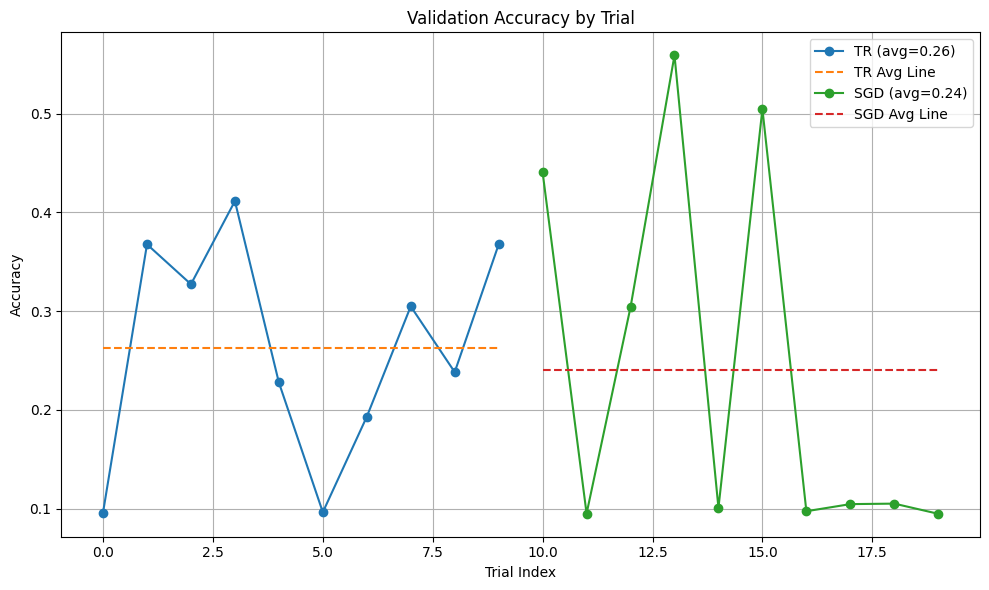

In [9]:
def evaluate_best_trials(result, data_dir, gpus_per_trial=0):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    accuracies = {}
    trial_data = []

    for optimizer in ["sgd", "tr"]:
        print(f"\nEvaluating best model for optimizer: {optimizer}")
        trials = [t for t in result.trials if t.config["optimizer"] == optimizer and t.last_result is not None]
        if not trials:
            print(f"No completed trials for optimizer {optimizer.upper()}")
            continue
        trial = max(trials, key=lambda t: t.last_result["accuracy"])
        model = Net(trial.config["l1"], trial.config["l2"])
        if gpus_per_trial > 1:
            model = nn.DataParallel(model)
        model.to(device)

        checkpoint = result.get_best_checkpoint(trial=trial, metric="accuracy", mode="max")
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                data = pickle.load(fp)
            model.load_state_dict(data["net_state_dict"])

        test_acc = test_accuracy(model, device)
        accuracies[optimizer.upper()] = test_acc
        print(f"Test accuracy for {optimizer.upper()}: {test_acc:.4f}")

    # Print table of all trials
    headers = ["Trial name", "status", "l1", "l2", "lr", "batch_size", "iter", "time (s)", "loss", "accuracy"]
    rows = []
    for trial in result.trials:
        config = trial.config
        result_data = trial.last_result if trial.last_result else {}
        rows.append([
            trial.trial_id,
            trial.status,
            config.get("l1", "-"),
            config.get("l2", "-"),
            f"{config.get('lr', 0):.5f}",
            config.get("batch_size", "-"),
            result_data.get("training_iteration", "-"),
            f"{result_data.get('time_total_s', 0):.1f}" if result_data else "-",
            f"{result_data.get('loss', 0):.4f}" if result_data else "-",
            f"{result_data.get('accuracy', 0):.4f}" if result_data else "-",
        ])
    print("\n" + tabulate(rows, headers=headers, tablefmt="grid"))

    return pd.DataFrame([
        {
            "trial_id": t.trial_id,
            "optimizer": t.config.get("optimizer", "-"),
            "accuracy": t.last_result.get("accuracy", 0) if t.last_result else 0
        }
        for t in result.trials if t.last_result is not None
    ])

def plot_results(trial_data):
    if not trial_data.empty:
        plt.figure(figsize=(10, 6))

        for opt in trial_data["optimizer"].unique():
            subset = trial_data[trial_data["optimizer"] == opt].sort_index()
            plt.plot(subset.index, subset["accuracy"], marker='o', label=f"{opt.upper()} (avg={subset['accuracy'].mean():.2f})")
            avg_line = [subset["accuracy"].mean()] * len(subset)
            plt.plot(subset.index, avg_line, linestyle='--', label=f"{opt.upper()} Avg Line")

        plt.title("Validation Accuracy by Trial")
        plt.xlabel("Trial Index")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

def main(num_samples=2, max_num_epochs=10, gpus_per_trial=0):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    search_space = []
    for i in range(num_samples):
        optimizer = "tr" if i < num_samples // 2 else "sgd"
        search_space.append({
            "l1": tune.choice([2**i for i in range(9)]),
            "l2": tune.choice([2**i for i in range(9)]),
            "lr": tune.loguniform(1e-3, 1e-1),
            "batch_size": tune.choice([2, 4, 8, 16]),
            "optimizer": optimizer
        })

    scheduler = ASHAScheduler(metric="loss", mode="min", max_t=max_num_epochs, grace_period=1, reduction_factor=2)

    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=tune.grid_search(search_space),
        scheduler=scheduler,
    )

    trial_data = evaluate_best_trials(result, data_dir, gpus_per_trial)
    plot_results(trial_data)

if __name__ == "__main__":
    main(num_samples=20, max_num_epochs=10, gpus_per_trial=0)


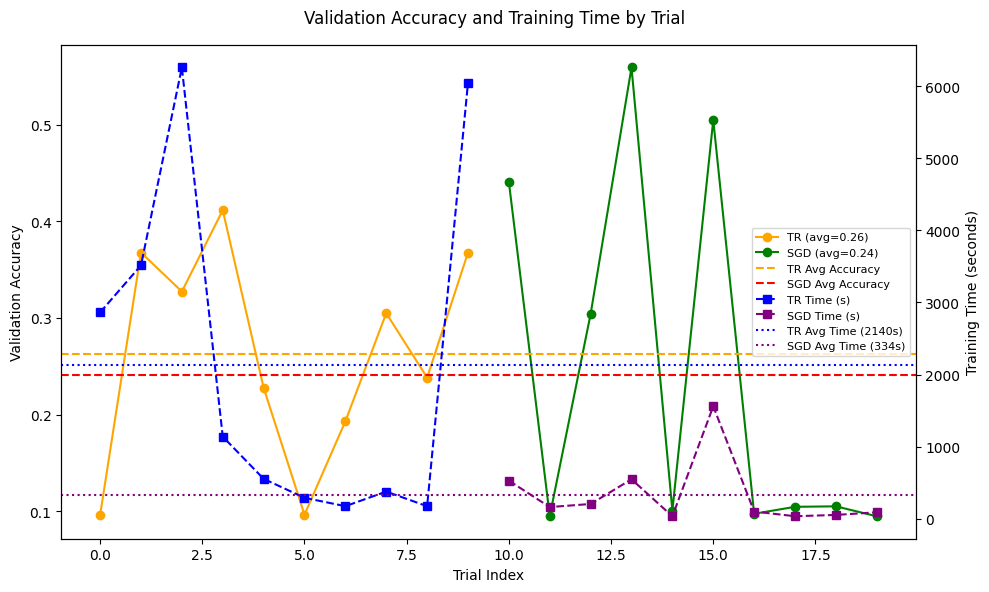

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Reconstruct your table into a DataFrame
data = {
    "optimizer": ["TR"] * 10 + ["SGD"] * 10,
    "trial": list(range(20)),
    "time": [
        2862.1, 3514.4, 6257.5, 1140.6, 555.4, 292.8, 176.4, 379.0, 176.3, 6044.5, # TR
        530.2, 164.0, 207.2, 549.1, 36.6, 1561.5, 102.6, 37.2, 55.3, 92.0  # SGD
    ],
    "accuracy": [
        0.096, 0.3676, 0.3272, 0.4114, 0.2277, 0.0963, 0.1930, 0.3048, 0.2382, 0.3675, # TR
        0.4405, 0.0949, 0.3040, 0.5591, 0.1006, 0.5047, 0.0973, 0.1045, 0.1050, 0.0947  # SGD
    ],
    "loss": [
        2.3091, 1.7389, 1.8955, 1.6011, 2.0390, 2.3238, 2.0823, 1.8259, 1.9938, 1.7707, # TR
        1.5908, 2.3491, 1.7917, 1.3512, 2.3107, 1.4129, 2.3447, 2.3074, 2.3149, 2.3089  # SGD
    ]
}

df = pd.DataFrame(data)

# Separate Trust Region and SGD trials
tr_trials = df[df["optimizer"] == "TR"]
sgd_trials = df[df["optimizer"] == "SGD"]

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot validation accuracy
ax1.plot(tr_trials["trial"], tr_trials["accuracy"], '-o', label=f'TR (avg={tr_trials["accuracy"].mean():.2f})', color='orange')
ax1.plot(sgd_trials["trial"], sgd_trials["accuracy"], '-o', label=f'SGD (avg={sgd_trials["accuracy"].mean():.2f})', color='green')

# Plot average accuracy lines
ax1.axhline(tr_trials["accuracy"].mean(), color='orange', linestyle='--', label='TR Avg Accuracy')
ax1.axhline(sgd_trials["accuracy"].mean(), color='red', linestyle='--', label='SGD Avg Accuracy')

ax1.set_xlabel('Trial Index')
ax1.set_ylabel('Validation Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Twin axis for training time
ax2 = ax1.twinx()

# Plot training time
ax2.plot(tr_trials["trial"], tr_trials["time"], 's--', color='blue', label='TR Time (s)')
ax2.plot(sgd_trials["trial"], sgd_trials["time"], 's--', color='purple', label='SGD Time (s)')

# Plot average training time lines
ax2.axhline(tr_trials["time"].mean(), color='blue', linestyle=':', label=f'TR Avg Time ({tr_trials["time"].mean():.0f}s)')
ax2.axhline(sgd_trials["time"].mean(), color='purple', linestyle=':', label=f'SGD Avg Time ({sgd_trials["time"].mean():.0f}s)')

ax2.set_ylabel('Training Time (seconds)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and Legends
fig.suptitle("Validation Accuracy and Training Time by Trial")

# Combine legends from both y-axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='center right', fontsize=8)

fig.tight_layout()
plt.show()
